In [1]:
import pandas as pd

df = pd.read_csv('dailygroundnut.csv')

df
import numpy as np

In [2]:
df = df[['Datetime', 'AvgPrice']]

In [3]:
final_test_date = df['Datetime'].max()  # Assuming 'final_test_date' is the column name for your test dates


In [4]:
# Convert 'datetime' column to datetime datatype
df['Datetime'] = pd.to_datetime(df['Datetime'], format='%d-%m-%Y')

# Set 'datetime' as index
df.set_index('Datetime', inplace=True)

print(df)

            AvgPrice
Datetime            
2011-01-01    3166.0
2011-01-02    2380.0
2011-01-03    4083.0
2011-01-04    4100.0
2011-01-05    4074.0
...              ...
2024-02-21    8070.0
2024-02-22    8000.0
2024-02-23    8015.0
2024-02-24    6940.0
2024-02-26    7975.0

[3607 rows x 1 columns]


In [5]:
df.head()

,AvgPrice
Datetime,
2011-01-01,3166.0
2011-01-02,2380.0
2011-01-03,4083.0
2011-01-04,4100.0
2011-01-05,4074.0


In [6]:
df.tail()

,AvgPrice
Datetime,
2024-02-21,8070.0
2024-02-22,8000.0
2024-02-23,8015.0
2024-02-24,6940.0
2024-02-26,7975.0


In [7]:
def create_features(df):
    """
    Create time series features based on time series index within the specified test size.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    # Ensure that 'weekofyear' is computed within the test window
    df['weekofyear'] = (df.index - df.index[0]).days // 7 + 1  # Compute week of the year relative to the start of the data
    return df

df = create_features(df)

In [8]:
def add_lags(df, target_column):
    """
    Add lag features to the DataFrame based on the specified lag offsets.
    """
    lag_offsets = [30 * i for i in range(1, 4)]  # Lag offsets in days: 30, 60, 90 (for 1, 2, 3 months)
    for lag, offset in enumerate(lag_offsets, start=1):
        df[f'lag{lag}'] = df.index - pd.Timedelta(days=offset)
        df[f'lag{lag}'] = df[f'lag{lag}'].map(target_column)
    return df


In [9]:
from pycaret.regression import *

exp = setup(df, target='AvgPrice', session_id = 123)

,Description,Value
0,Session id,123
1,Target,AvgPrice
2,Target type,Regression
3,Original data shape,"(3607, 8)"
4,Transformed data shape,"(3607, 8)"
5,Transformed train set shape,"(2524, 8)"
6,Transformed test set shape,"(1083, 8)"
7,Numeric features,7
8,Preprocess,True
9,Imputation type,simple


In [10]:
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,330.1063,271976.5979,516.5110,0.9001,0.0805,0.0526,0.1240
rf,Random Forest Regressor,324.3601,287702.5074,531.3477,0.8937,0.0829,0.0516,0.1570
xgboost,Extreme Gradient Boosting,339.5629,296154.9750,539.4448,0.8910,0.0838,0.0540,0.0330
gbr,Gradient Boosting Regressor,380.0649,306348.3887,550.6140,0.8873,0.0863,0.0605,0.0480
et,Extra Trees Regressor,338.8663,307444.9306,550.0393,0.8864,0.0862,0.0542,0.1260
knn,K Neighbors Regressor,434.2249,451678.4625,669.2259,0.8321,0.1054,0.0712,0.0130
dt,Decision Tree Regressor,396.3296,460826.8732,674.2069,0.8290,0.1065,0.0628,0.0100
ada,AdaBoost Regressor,668.4519,654102.5336,807.0001,0.7587,0.1317,0.1094,0.0270
lr,Linear Regression,751.0238,860511.0599,926.3986,0.6824,0.1496,0.1216,0.9730
lar,Least Angle Regression,747.8801,861993.5262,927.1648,0.6818,0.1502,0.1213,0.0090


In [11]:
print(best)

LGBMRegressor(n_jobs=-1, random_state=123)


In [12]:
finalized_model = finalize_model(best)

In [13]:
# predict on test set
holdout_pred = predict_model(best)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,338.9589,310149.6993,556.9109,0.8866,0.0868,0.0546


In [14]:
# show predictions df
holdout_pred

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,AvgPrice,prediction_label
Datetime,,,,,,,,,
2013-05-22,2,2,5,2013,142,22,125,5753.0,5574.593636
2019-07-26,4,3,7,2019,207,26,447,8305.0,8563.945769
2014-01-28,1,1,1,2014,28,28,161,4352.5,4289.387085
2017-01-10,1,1,1,2017,10,10,315,6142.0,6606.069382
2016-04-28,3,2,4,2016,119,28,278,6872.5,6523.732487
...,...,...,...,...,...,...,...,...,...
2015-03-27,4,1,3,2015,86,27,221,6065.0,5794.663204
2021-04-21,2,2,4,2021,111,21,538,8390.0,8501.355117
2013-01-11,4,1,1,2013,11,11,106,6478.0,6425.444398


In [15]:
holdout_pred.index.max()

Timestamp('2024-02-26 00:00:00')

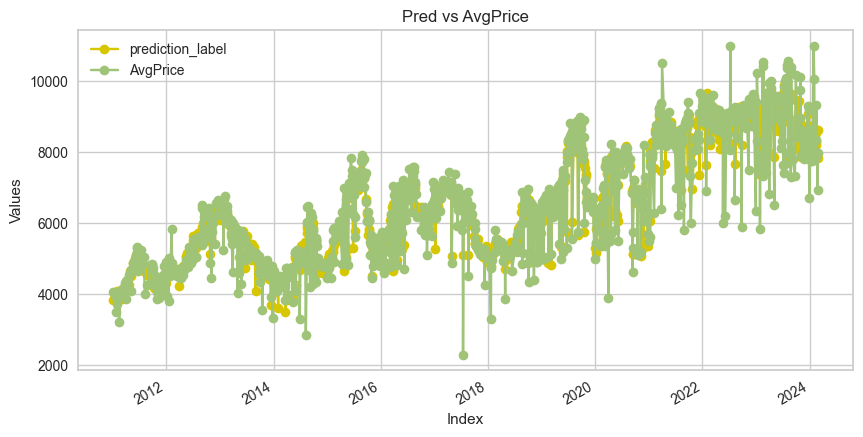

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

color_pal = sns.color_palette()
ax = holdout_pred[['prediction_label', 'AvgPrice']].plot(figsize=(10, 5),
                                                         color=[color_pal[4], color_pal[1]],
                                                         marker='o',
                                                         linestyle='-',
                                                         title='Pred vs AvgPrice')
ax.set_xlabel("Index")
ax.set_ylabel("Values")
plt.show()

In [33]:
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [17]:
future = pd.date_range('2024-02-26', '2025-05-31', freq = 'M')
future_df = pd.DataFrame(index=future)

In [18]:
future_df['isFuture'] = True

In [19]:
df['isFuture'] = False

In [20]:
df_and_future = pd.concat([df, future_df])

In [21]:
df_and_future

,AvgPrice,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,isFuture
2011-01-01,3166.0,5.0,1.0,1.0,2011.0,1.0,1.0,1.0,False
2011-01-02,2380.0,6.0,1.0,1.0,2011.0,2.0,2.0,1.0,False
2011-01-03,4083.0,0.0,1.0,1.0,2011.0,3.0,3.0,1.0,False
2011-01-04,4100.0,1.0,1.0,1.0,2011.0,4.0,4.0,1.0,False
2011-01-05,4074.0,2.0,1.0,1.0,2011.0,5.0,5.0,1.0,False
...,...,...,...,...,...,...,...,...,...
2025-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2025-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2025-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2025-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [22]:
df_and_future = create_features(df_and_future)

In [23]:
future_with_features = df_and_future.query('isFuture').copy()

In [24]:
future_with_features

,AvgPrice,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,isFuture
2024-02-29,NaN,3,1,2,2024,60,29,687,True
2024-03-31,NaN,6,1,3,2024,91,31,692,True
2024-04-30,NaN,1,2,4,2024,121,30,696,True
2024-05-31,NaN,4,2,5,2024,152,31,700,True
2024-06-30,NaN,6,2,6,2024,182,30,705,True
2024-07-31,NaN,2,3,7,2024,213,31,709,True
2024-08-31,NaN,5,3,8,2024,244,31,714,True
2024-09-30,NaN,0,3,9,2024,274,30,718,True
2024-10-31,NaN,3,4,10,2024,305,31,722,True
2024-11-30,NaN,5,4,11,2024,335,30,727,True


In [25]:
clean_data = future_with_features.drop(columns=['AvgPrice'])

In [26]:
future_with_features = clean_data

In [27]:
future_with_features

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,isFuture
2024-02-29,3,1,2,2024,60,29,687,True
2024-03-31,6,1,3,2024,91,31,692,True
2024-04-30,1,2,4,2024,121,30,696,True
2024-05-31,4,2,5,2024,152,31,700,True
2024-06-30,6,2,6,2024,182,30,705,True
2024-07-31,2,3,7,2024,213,31,709,True
2024-08-31,5,3,8,2024,244,31,714,True
2024-09-30,0,3,9,2024,274,30,718,True
2024-10-31,3,4,10,2024,305,31,722,True
2024-11-30,5,4,11,2024,335,30,727,True


In [28]:
predictions = predict_model(best, data = future_with_features)

In [29]:
predictions

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,isFuture,prediction_label
2024-02-29,3,1,2,2024,60,29,687,True,7848.060524
2024-03-31,6,1,3,2024,91,31,692,True,7993.323765
2024-04-30,1,2,4,2024,121,30,696,True,8460.888323
2024-05-31,4,2,5,2024,152,31,700,True,8575.527415
2024-06-30,6,2,6,2024,182,30,705,True,7828.492311
2024-07-31,2,3,7,2024,213,31,709,True,8547.566134
2024-08-31,5,3,8,2024,244,31,714,True,7611.596316
2024-09-30,0,3,9,2024,274,30,718,True,8889.986503
2024-10-31,3,4,10,2024,305,31,722,True,8081.575274
2024-11-30,5,4,11,2024,335,30,727,True,7784.536230


In [30]:
predictions.to_csv('pycaret_predictions.csv', index = True)

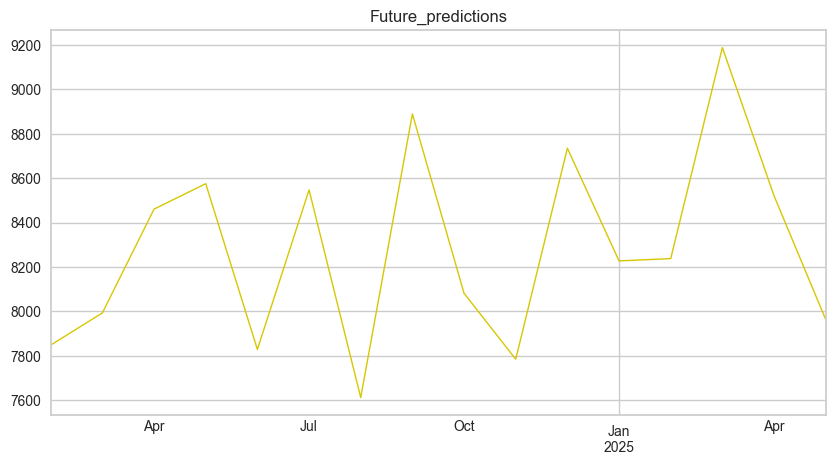

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
color_pal = sns.color_palette()
predictions['prediction_label'].plot(figsize=(10, 5),
                         color=color_pal[4],
                         ms=1,
                         lw=1,
                         title='Future_predictions')
plt.show()